# Triple-Halide Perovskites: Contour Map
KB 2022-01-02
hello

In [1]:
## Load packages
import grama as gr
import numpy as np
import plotnine as pt
import pandas as pd

## Load scikit tools
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

## Package setup
DF = gr.Intention()

## Helper functions

In [2]:
## Barycentric converter
def tran_bary(df, a="I", b="Br", c="Cl", x="x", y="y"):
    r"""Convert to barycentric coordinates
    """
    df_tmp = df.copy()
    df_tmp[x] = 0.0 * df[a] + 1.0 * df[b] + 0.5 * df[c]
    df_tmp[y] = 0.0 * df[a] + 0.0 * df[b] + np.sqrt(1 - 0.5**2) * df[c]
    
    return df_tmp

## Inverse transform
def tran_thp(df, x="x", y="y", a="I", b="Br", c="Cl"):
    df_tmp = df.copy()
    xa = 0; ya = 0
    xb = 1; yb = 0
    xc = 0.5; yc = np.sqrt(1 - 0.5**2)
    d = (yb - yc) * (xa - xc) + (xc - xb) * (ya - yc)
    df_tmp[a] = ((yb - yc) * (df_tmp[x] - xc) + (xc - xb) * (df_tmp[y] - yc)) / d
    df_tmp[b] = ((yc - ya) * (df_tmp[x] - xc) + (xa - xc) * (df_tmp[y] - yc)) / d
    df_tmp[c] = 1 - df_tmp[a] - df_tmp[b]

    return df_tmp

# Pipe-enabled function
tf_bary = gr.add_pipe(tran_bary)
tf_thp = gr.add_pipe(tran_thp)
# Triangle boundary
df_tri_bounds = (
    gr.df_make(
        Br=[1, 0, 0, 1],
        Cl=[0, 1, 0, 0],
        I =[0, 0, 1, 0],
    )
    >> tf_bary()
)
# Labels
df_tri_labels = (
    gr.df_make(
        x=[-0.1, +1.1, +0.5],
        y=[+0.0, +0.0, +np.sqrt(1 - 0.5**2) + 0.1],
        label=["I", "Br", "Cl"]
    )
)

# Generate Example Data

In [3]:
## Made Up Triple Halide Perovskite data: 
df_thp_fake1 = (
    ## I -- Br tie
    gr.df_make(
        Br=np.linspace(0, 1, num=6),
        Cl=0,
        single_phase=True,
    )
    >> gr.tf_mutate(I=1 - DF.Br)
    
    ## Cl -- Br tie
    >> gr.tf_bind_rows(
        gr.df_make(
            Br=np.linspace(0, 0.99, num=6),
            I=0,
            single_phase=True,
        )
    >> gr.tf_mutate(Cl=1 - DF.Br)
    )    
    ## I -- Cl tie
    >> gr.tf_bind_rows(
        gr.df_make(
            Cl =np.linspace(0.1, 0.9, num=5),
            Br =0,
            single_phase=False,
        )
    >> gr.tf_mutate(I= 1 - DF.Cl)
    )    
    ## Middle of Cl -- I
    # Replicate single point to weight against densely-sampled edges
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.10, I=0.40, Br=[0.50] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.80, I=0.10, Br=[0.10] * 1, single_phase=True)
    )
    >> tf_bary()
)

In [4]:
## Real Triple Halide Perovskite data: 
df_thp_round1 = ( 
    ## I -- Br tie: MAPbBr1.5I1.5 = True
    gr.df_make(Cl=0, I=0.5, Br=[0.5] * 1, single_phase=True)
    
    ## Cl -- Br tie: MAPbBrCl = True
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0, Br=[0.5] * 1, single_phase=True)
    )  
    
    ## I -- Cl tie: MAPbI1.5Cl1.5 = False
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0.5, Br=[0] * 1, single_phase=False)
    )
    
    ## Middle of plot
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=True)
    )

    ## Convert to barycentric coordinates
    >> tf_bary()
)

In [5]:
## Real Triple Halide Perovskite data: #Amy has double checked all these points :)
df_thp_round1corners = ( #NEEDS RBF length = 0.6
    ## I -- Br tie: MAPbBr1.5I1.5 = True
    gr.df_make(Cl=0, I=0.5, Br=[0.5] * 1, single_phase=True)
    
    ## Cl -- Br tie: MAPbBrCl = True
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0, Br=[0.5] * 1, single_phase=True)
    )  
    
    ## I -- Cl tie: MAPbI1.5Cl1.5 = False
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0.5, Br=[0] * 1, single_phase=False)
    )
    
    ## Middle of plot
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=True)
    )
    
    ## Corners
    >> gr.tf_bind_rows(
        gr.df_make(Cl=1, I=0, Br=[0] * 1, single_phase=True)
    )  
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0, I=1, Br=[0] * 1, single_phase=True)
    )  
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0, I=0, Br=[1] * 1, single_phase=True)
    )  

    ## Convert to barycentric coordinates
    >> tf_bary()
)

In [6]:
## Real Triple Halide Perovskite data: #Using points along 50% contour line :)
df_thp_round2 = ( #NEEDS RBF length = 0.09
    ## I -- Br tie: MAPbBr1.5I1.5 = True
    gr.df_make(Cl=0, I=0.5, Br=[0.5] * 1, single_phase=True)
    
    ## Cl -- Br tie: MAPbBrCl = True
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0, Br=[0.5] * 1, single_phase=True)
    )  
    
    ## I -- Cl tie: MAPbI1.5Cl1.5 = False
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.5, I=0.5, Br=[0] * 1, single_phase=False)
    )
    
    ## Middle of plot
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.33, I=0.33, Br=[0.34] * 1, single_phase=True)
    )
    
    ## Corners
    >> gr.tf_bind_rows(
        gr.df_make(Cl=1, I=0, Br=[0] * 1, single_phase=True)
    )  
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0, I=1, Br=[0] * 1, single_phase=True)
    )  
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0, I=0, Br=[1] * 1, single_phase=True)
    )  
    
    ## Round 2 Points
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.45, I=0.4, Br=[0.15] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.28, I=0.6, Br=[0.12] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.24, I=0.71, Br=[0.05] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.35, I=0.5, Br=[0.15] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.71, I=0.24, Br=[0.05] * 1, single_phase=False)
    )
    >> gr.tf_bind_rows(
        gr.df_make(Cl=0.60, I=0.28, Br=[0.12] * 1, single_phase=False)
    )

    ## Convert to barycentric coordinates
    >> tf_bary()
)

# Visualize Data

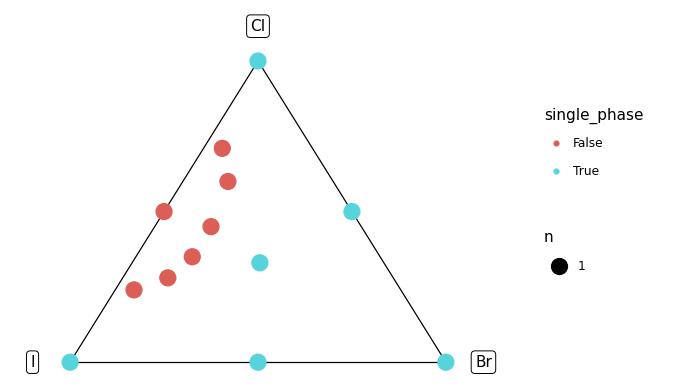

<ggplot: (128629812971)>

In [7]:
#Select data to display:
df_thp = df_thp_round2 # Currently using all round2 and round1 data
length = 0.09 #for radial basis function tuning

#Show visualization
(
    df_thp
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_count(pt.aes(color="single_phase"))
    + pt.theme_void()
    + pt.theme(
        plot_background=pt.element_rect(fill="white")
    )
)

# Make Gaussian Process Model

Note that the following code trains the model in composition space `["Cl", "Br", "I"]`, but builds a Grama model that accepts barycentric coordinates `["x", "y"]`. This is to enable contour plotting below.

In [8]:
## Set up training data
var = ["Cl", "Br", "I"]
out = ["single_phase"]
df_train = (
    df_thp
    >> tf_bary()
)
X = df_train[var].values
Y = np.atleast_2d(df_train[out].values)

## Set GP hyperparameters
#length = 0.09
kernel = 1.0 * RBF(length)
## Fit the model
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, Y)

## Assemble the model
md_gpc = (
    gr.Model()
    ## Use barycentric conversion to produce Cl, Br, I values
    >> gr.cp_vec_function(
        fun=tran_thp,
        var=["x", "y"],
        out=var,
    )
    ## Include the fitted GPR as a grama function
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(pr_single_phase=gpr.predict(df[var].values).flatten()),
        var=var,
        out=["pr_single_phase"],
    )
    ## Include bounds on x, y; note that not all x,y value pairs will be
    # valid compositions, so we'll need to filter data in-practice
    >> gr.cp_bounds(
        x=(0, 1),
        y=(0, 1),
    )
)

Display model predictions in barycentric coordinates

... provided columns intersect model output.
tran_md() is dropping {'I', 'Br', 'Cl'}


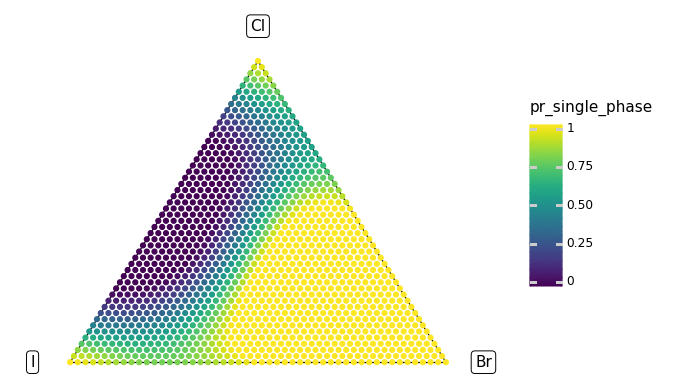

<ggplot: (128629969387)>

In [9]:
(
    gr.df_make(Br=np.linspace(0, 1, num=50))
    >> gr.tf_outer(
        df_outer=gr.df_make(Cl=np.linspace(0, 1, num=50))
    )
    >> gr.tf_filter(DF.Br + DF.Cl <= 1)
    >> gr.tf_mutate(I=1 - DF.Br - DF.Cl)
    >> tf_bary()
    >> gr.tf_md(md_gpc)
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
    + pt.geom_point(pt.aes(color="pr_single_phase"))
    
    + pt.scale_color_continuous(limits=(0, 1))
    + pt.theme_void()
    + pt.theme(
        plot_background=pt.element_rect(fill="white")
    )
)

# Make Contour Map

First, generate contour data; this same data will be used to visualize the contours, and to generate candidates via support points.

In [18]:
# Generate contour data
df_contour = (
    md_gpc
    >> gr.ev_contour(
        var=["x", "y"],
        out=["pr_single_phase"],
        levels = dict(pr_single_phase=[-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1]),
        n_side = 128, #smoothness of lines, granularity
        #n_levels = 12
    )
    ## Convert x, y -> I, Br, Cl
    >> tf_thp()
    >> tf_thp(x="x_end", y="y_end", a="I_end", b="Br_end", c="Cl_end")
    ## Filter to remove invalid compositions
    >> gr.tf_filter(
        0 <= DF.I, DF.I <= 1,
        0 <= DF.Br, DF.Br <= 1,
        0 <= DF.I, DF.I <= 1,
        0 <= DF.I_end, DF.I_end <= 1,
        0 <= DF.Br_end, DF.Br_end <= 1,
        0 <= DF.I_end, DF.I_end <= 1,
    )
)

Visualize the contour data

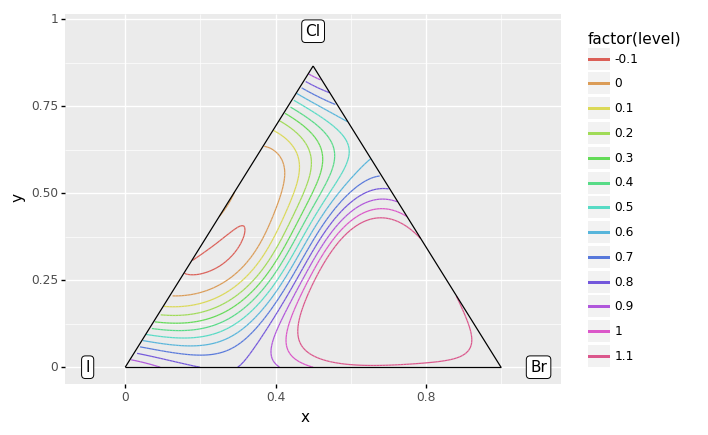

<ggplot: (128629857389)>

In [19]:
(
    df_contour
    ## Visualize
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_segment(gr.aes(xend="x_end", yend="y_end", group="level", color="factor(level)"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
)
    

Based on the most recent conversation with Becky (2022-02-16), the `0.5` probability contour seems to be ideal. We aim to propose candidates along this contour.

# Using support points to propose candidates

We can't run thousands of candidates all along the desired contour. Instead, we can use the support points algorithm (`gr.tf_sp()`) to propose candidates that lie along the desired contour.

tran_sp finished in 64 iterations with distance criterion 9.766e-04


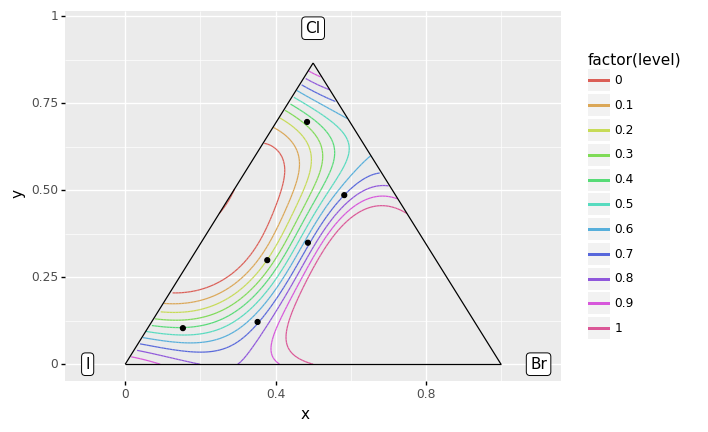

<ggplot: (128630004968)>

In [12]:

## Select candidates using support points
df_sp = (
    df_contour
    # Will need to select the 0.5 probability contour *only*
    >> gr.tf_sp(
        n=6,           # Number of candidates
        var=["x", "y"], # Target variables
    )
)

## Visualize the support points along contours, as a sanity check
(
    df_contour
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_segment(pt.aes(xend="x_end", yend="y_end", group="level", color="factor(level)"))
    + pt.geom_segment(
        data=df_tri_bounds,
        mapping=pt.aes(xend="gr.lead(x)", yend="gr.lead(y)")
    )
    + pt.geom_point(data=df_sp)
    + pt.geom_label(
        data=df_tri_labels,
        mapping=pt.aes(label="label")
    )
)

In [13]:
df_sp.head()
#These are in barycentric x,y coordinates
#Supports single phase mapping question

,x,y
0,0.582900,0.486132
1,0.486146,0.349291
2,0.352189,0.121523
3,0.378014,0.299158
4,0.483876,0.696522


In [14]:
#Here are points calculated with percent compositions of each halide
df_sp2 = tran_thp(df_sp)

##Sanity check, do percent compositions add up to 1?
df_sp2 = gr.tran_mutate(df_sp2, total=DF.Br + DF.Cl + DF.I)
df_sp2 = gr.tran_mutate(df_sp2, valid=gr.abs(DF.total - 1) < 1e-6)
df_sp2


,x,y,I,Br,Cl,total,valid
0,0.582900,0.486132,0.136431,0.302232,0.561337,1.0,True
1,0.486146,0.349291,0.312191,0.284483,0.403327,1.0,True
2,0.352189,0.121523,0.577650,0.282027,0.140323,1.0,True
3,0.378014,0.299158,0.449267,0.205295,0.345438,1.0,True
4,0.483876,0.696522,0.113987,0.081739,0.804275,1.0,True
5,0.153416,0.103709,0.786708,0.093540,0.119753,1.0,True


In [15]:
#type(df_sp2.total)

In [16]:
#df_sp2.total.values[3]

In [17]:
from pathlib import Path  
filepath = Path('Data\\perovskite50compo.csv')  #\\Users\\kayla\\python_work\\perovskite-solar\\
df_sp2.to_csv(filepath, header=['xCoord', 'yCoord', "Iodine Fraction", "Bromine Fraction","Chlorine Fraction", 'total', 'valid within 1e-6'] 
             )